# Elliptic woth Neumann boundary conditions

We aim to solve an elliptic linear PDE of the form 

$$
Lu = \xi \\
\nabla u \cdot  \bold{n}= \frac{\partial}{\partial \bold{n}}u=0
$$

We need to form the matrix 

$$
\Theta = \begin{bmatrix}
  \frac{\partial}{\partial \bold{n}_x} \frac{\partial}{\partial \bold{n}_y} K(X_{\partial\Omega},X_{\partial\Omega}) & \int L_y  \frac{\partial}{\partial \bold{n}_x} K(X_{\partial\Omega}, y)\psi \\
\int L_y \frac{\partial}{\partial \bold{n}_x}  K(X_{\partial\Omega}, y)\psi ^\intercal & \int \int  L_y L_x K( x, y) \psi(x)\psi(y)
\end{bmatrix}
$$

In [1]:
from jax.config import config
config.update("jax_enable_x64", True)

from utils_elliptic_coef_neumann import *

import jax.numpy as jnp
from jax import jit, vmap

import matplotlib.pyplot as plt 

from jax import grad



from jax import random

/tmp/ipykernel_3195371/1058337782.py:1: DeprecationWarning: Accessing jax.config via the jax.config submodule is deprecated.
  from jax.config import config


In [2]:
def grad_matern_kernel_x(x, y, length_scale):
    nabla = grad(matern_kernel, argnums = 0)(x, y, length_scale)
    nabla = jnp.where(jnp.allclose(x,y), 0, nabla)

    return nabla

def double_grad_matern_kernel(x, y, length_scale):
    nabla = grad(grad_matern_kernel_x, argnums = 1)(x, y, length_scale)
    nu = 5/2
    nabla = jnp.where(jnp.allclose(x,y), -2*nu/(2*(1-nu)*length_scale), nabla)

    return nabla

vmap_grad_matern_kernel = vmap(vmap(double_grad_matern_kernel, in_axes = (0, None, None)), in_axes = (None, 0, None))

In [3]:
x = jnp.linspace(0, 1, 500)
length_scale = 1.0
x

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


Array([0.        , 0.00200401, 0.00400802, 0.00601202, 0.00801603,
       0.01002004, 0.01202405, 0.01402806, 0.01603206, 0.01803607,
       0.02004008, 0.02204409, 0.0240481 , 0.0260521 , 0.02805611,
       0.03006012, 0.03206413, 0.03406814, 0.03607214, 0.03807615,
       0.04008016, 0.04208417, 0.04408818, 0.04609218, 0.04809619,
       0.0501002 , 0.05210421, 0.05410822, 0.05611222, 0.05811623,
       0.06012024, 0.06212425, 0.06412826, 0.06613226, 0.06813627,
       0.07014028, 0.07214429, 0.0741483 , 0.0761523 , 0.07815631,
       0.08016032, 0.08216433, 0.08416834, 0.08617234, 0.08817635,
       0.09018036, 0.09218437, 0.09418838, 0.09619238, 0.09819639,
       0.1002004 , 0.10220441, 0.10420842, 0.10621242, 0.10821643,
       0.11022044, 0.11222445, 0.11422846, 0.11623246, 0.11823647,
       0.12024048, 0.12224449, 0.1242485 , 0.12625251, 0.12825651,
       0.13026052, 0.13226453, 0.13426854, 0.13627255, 0.13827655,
       0.14028056, 0.14228457, 0.14428858, 0.14629259, 0.14829

In [4]:
grad_matern_kernel_x(x[0], x[2], length_scale)

Array(0.00667976, dtype=float64)

In [5]:
double_grad_matern_kernel(x[0], x[0], length_scale)

Array(1.66666667, dtype=float64)

In [6]:
K_grad = vmap_grad_matern_kernel(x, x, length_scale)
K = vmap_kernel(x, x, length_scale)

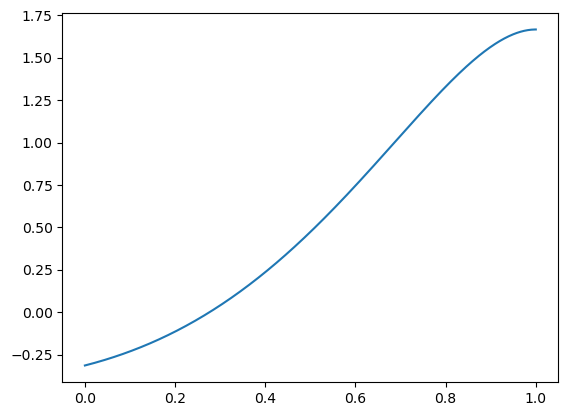

In [7]:
plt.plot(x, K_grad[500])

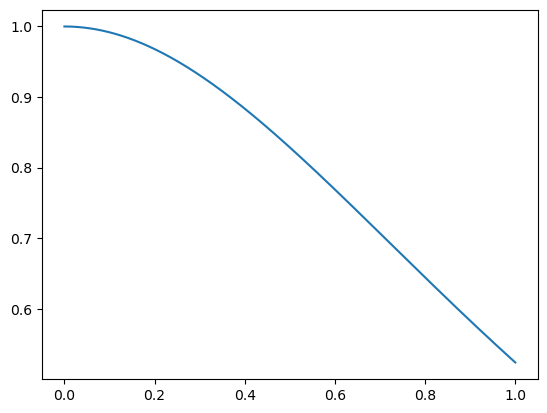

In [8]:
plt.plot(x, K[0])

In [9]:
import importlib
import utils_elliptic_coef_neumann  # replace with your module name

# Make some changes to some_module here

# Force reload the module
importlib.reload(utils_elliptic_coef_neumann)
from utils_elliptic_coef_neumann import *

In [10]:
K_boundary = vmap_boundary_x_interior_y_kernel(x,x, length_scale, 0.01, 10.0)

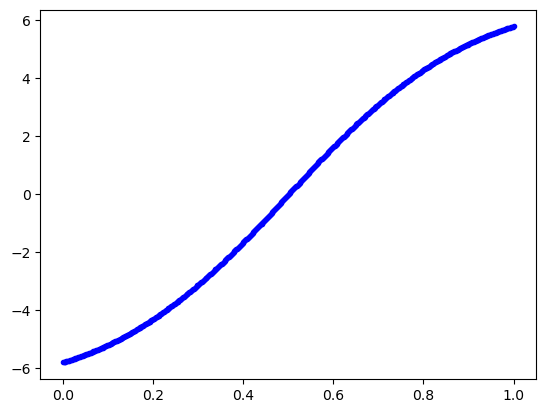

In [11]:
plt.plot(x, K_boundary[x.shape[0]//2],'b.', )

In [12]:
K_boundary[50, 51]

Array(0.03389782, dtype=float64)

In [13]:
# Force reload the module
importlib.reload(utils_elliptic_coef_neumann)
from utils_elliptic_coef_neumann import *

# Generating an example


Let us solve 
\begin{aligned}
 -\varepsilon \Delta u -b(x)u &= f \quad x \in \Omega\\
\frac{\partial}{\partial \nu}u &= 0 \quad x \in \partial \Omega
\end{aligned}

If 
$$
u =  \sqrt{\frac{2}{L}}\sum_{i}^\infty c_i \cos\Big(\frac{n\pi x}{L}\Big)
$$

Then 
$$
f =  \sqrt{\frac{2}{L}} \sum_{i}^\infty  \Big(\varepsilon\frac{n^2\pi^2}{L^2} - b(x)\Big)c_i \cos\Big(\frac{n\pi x}{L}\Big)
$$

In [15]:
def evaluate_function(x, coef, L):
    values = 0
    for i, c in enumerate(coef):
        values +=c*jnp.cos((i+1)*jnp.pi*x/L)*jnp.sqrt(2/L)
    return values

In [16]:
b = lambda x: x**2 + 1

5.25


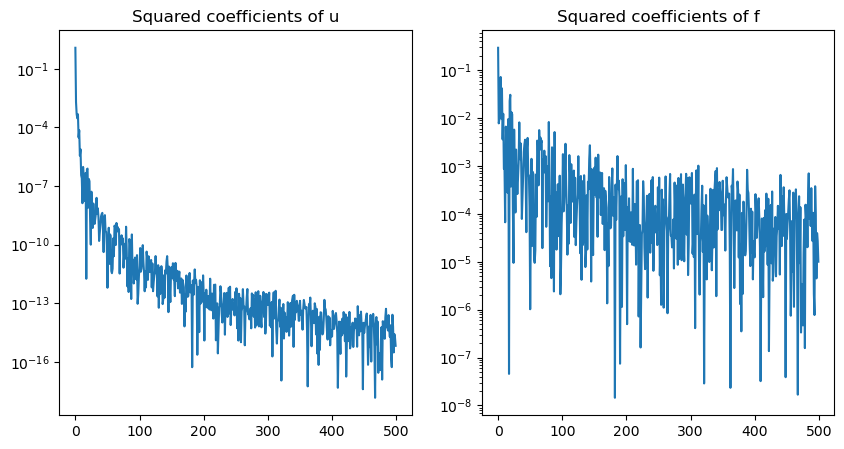

Text(0.5, 1.0, 'Function f')

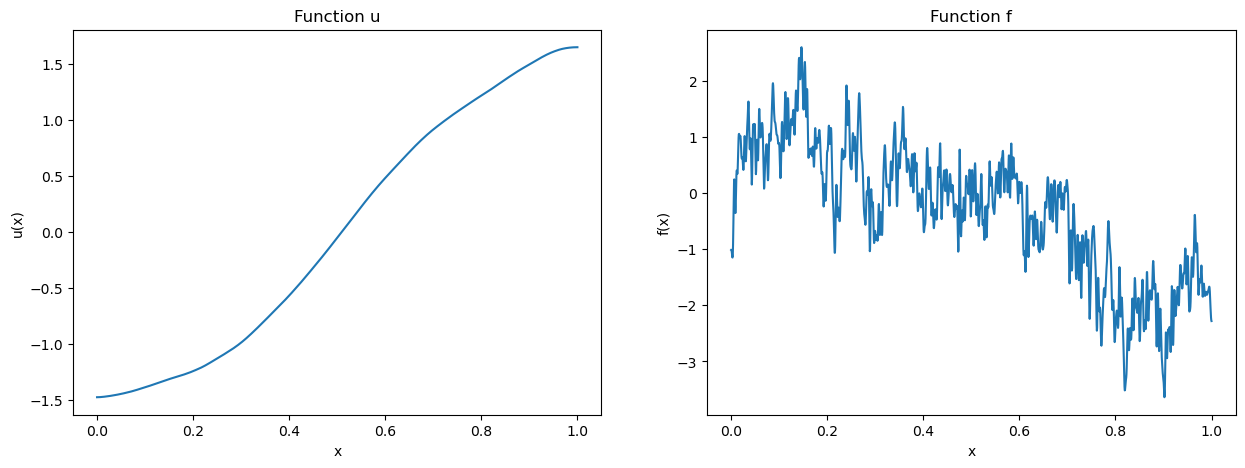

In [21]:
# Create the RHS

epsilon = 0.05

# draw random values for the coefficients
key = random.PRNGKey(54)

n_coef = 500

s = 2
alpha = 2*s+1 + 0.25
print(alpha)
decay_u = alpha/2
L = 1 # Lenght of the domain
coef_u =  jnp.ones(shape = (1, ))/(jnp.arange(1, n_coef+1)**(decay_u)) #jnp.ones(shape = (1, ))#random.normal(key, shape=(n_coef,))/(jnp.arange(1, n_coef+1)**(decay_u))

coef_u = random.normal(key, shape=(n_coef,))/(jnp.arange(1, n_coef+1)**(decay_u))
coef_f = coef_u*(epsilon*jnp.arange(1, n_coef+1)**(2)*jnp.pi**2*L**2)

x = jnp.linspace(0, L, 2000)
u_values = evaluate_function(x, coef_u, L=L)
f_values = evaluate_function(x, coef_f, L=L) - b(x)*u_values

# Plot both the coeffients of u and f in 2 subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.plot(coef_u**2)
ax1.set_yscale('log')
ax1.set_title('Squared coefficients of u')
ax2.plot(coef_f**2)
ax2.set_yscale('log')
ax2.set_title('Squared coefficients of f')

plt.show()

# Create 2 plots for the  function u and f
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].plot(x, u_values)
ax[0].set_xlabel("x")
ax[0].set_ylabel("u(x)")
ax[0].set_title("Function u")

ax[1].plot(x, f_values)
ax[1].set_xlabel("x")
ax[1].set_ylabel("f(x)")
ax[1].set_title("Function f")

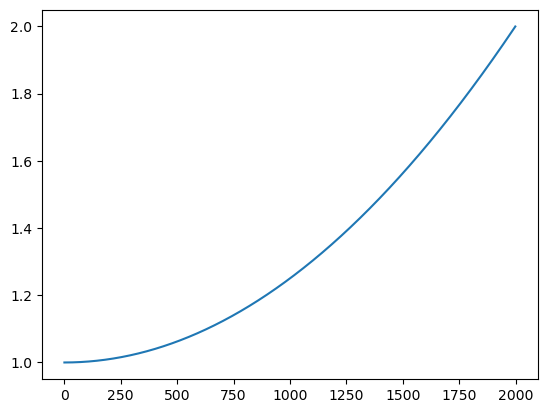

In [22]:
plt.plot(b(x))

## Create measurements of the RHS

In [23]:
from scipy.special import roots_legendre
from utils_rough_pde import vmap_root_interval, indicator_vector

In [33]:
lower, upper = 0.0, 1.0

boundary = jnp.array([[lower, upper]]).T
L =upper -lower 

# Construct the measurements
n_meas = 200
epsilon_values =  jnp.array([L/(n_meas*2)])
loc_values = jnp.linspace(lower , upper,  int(L/(2*epsilon_values[0])))
support = jnp.array([loc_values - epsilon_values[0], loc_values + epsilon_values[0]]).T
vol = support[:,1] - support[:,0]
N_test_functions = loc_values.shape[0]

In [34]:
from scipy.special import roots_legendre
n_order = 20
x_q, w_q = roots_legendre(n_order)
x_interval, w_interval = vmap_root_interval(x_q, w_q, support)

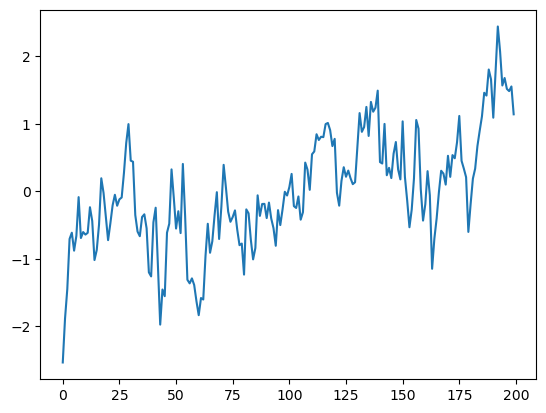

In [35]:
from utils_rough_pde import vmap_integrate_f_test_functions
# Create measurements of f 
root_psi, w_psi = vmap_root_interval(x_q, w_q, support)
psi_matrix = indicator_vector(root_psi, epsilon_values, loc_values)
psi_matrix = psi_matrix * w_psi

# Compute the RHS of the linear system
f_quad = evaluate_function(root_psi, coef_f, L)
f_meas = vmap_integrate_f_test_functions(f_quad, psi_matrix)

plt.plot(f_meas)

In [42]:
# Create the array of b values
b_root = b(root_psi)
bc = jnp.zeros(shape = (2, )) 

In [53]:
# Force reload the module
importlib.reload(utils_elliptic_coef_neumann)
from utils_elliptic_coef_neumann import *

In [63]:
boundary.shape,  psi_matrix.shape, root_psi.shape, b_root.shape

((2, 1), (200, 20), (200, 20), (200, 20))

In [70]:
boundary.shape, epsilon, root_psi[0].shape

((2, 1), 0.05, (20,))

In [74]:
K_boundary = vmap_boundary_x_interior_y_kernel(boundary[:, 0], root_psi[0], length_scale, 0.01, 10.0)

In [78]:
vmap_boundary_x_interior_y_kernel(boundary, root_psi[0], length_scale,epsilon, 10.0).shape

(20, 2)

In [84]:
L_b_y(boundary, root_psi[0], length_scale, epsilon, b_root[0])

Array([-0.00388911, -0.00388912, -0.00388912, -0.00388912, -0.00388912,
       -0.00388912, -0.00388912, -0.00388913, -0.00388913, -0.00388913,
       -0.00388913, -0.00388913, -0.00388913, -0.00388912, -0.00388912,
       -0.00388912, -0.00388912, -0.00388912, -0.00388912, -0.00388911],      dtype=float64)

In [64]:
linear_form_boundary_K(psi_matrix[0], boundary, root_psi[0], length_scale, epsilon, b_root[0])

TypeError: Gradient only defined for scalar-output functions. Output had shape: (20,).

In [57]:
length_scale = 1.0
theta_11, theta_21, theta_22 = theta_blocks(boundary,psi_matrix, root_psi, length_scale, jnp.array(epsilon), b_root)
theta_12 = theta_21.T

TypeError: Gradient only defined for scalar-output functions. Output had shape: (20,).